# pyRFF
> A python package for sampling approximate functions from a Gaussian Process.

- toc: true
- categories: [python package, gaussian process, bayesian optimization]
- image: images/pyrff.png

[pyRFF](https://github.com/michaelosthege/pyrff) is a package for Random Fourier Features, also known as spectra sampling, which is a method for sampling approximate functions from a Gaussian Process.

The method works for
* Matern kernels (in principle any stationary kernel should be feasible but its spectral distribution would need to be implemented)
* additive iid normal distributed noise, justifying a normal likelihood

## Example
We set up some 1D function and draw some 6 observations from it.

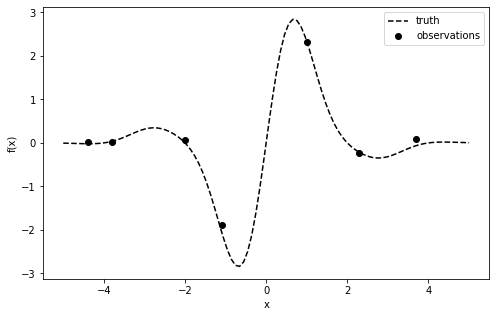

In [1]:
#collapse-hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.gaussian_process as skgp
import pyrff

bounds = [-5, 5]
x_grid = np.linspace(*bounds, num=100)

def f_true(x):
    return (3 * np.sin(0.5 * np.pi * x) + np.sin(np.pi * x) / 1.5) * np.exp(- x**2 / 4)

def f(x, σ=0.1):
    return f_true(x) + σ * np.random.randn(len(x))
    
# observations
np.random.seed(42)
X_obs = X_obs = np.array([-4.4, -3.8, -2, -1.1, 1.0, 2.3, 3.7])
Y_obs = f(X_obs)

def plot_data():
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x_grid, f_true(x_grid), 'k--', label="truth")
    ax.scatter(X_obs, Y_obs, color="k", label="observations", zorder=10)
    ax.set(xlabel="x", ylabel="f(x)")
    
plot_data()
plt.legend();

We can now go about fitting a GP with an RBF kernel to the observations.

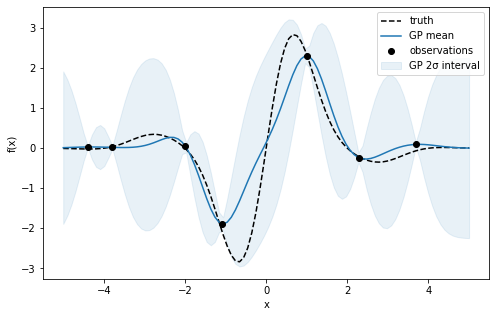

In [2]:
#collapse-hide
def fit_gp(X, Y):
    k_cov = skgp.kernels.RBF(1, (0.5, 2))
    k_scaling = skgp.kernels.ConstantKernel(1, (0.1, 5))
    k_noise = skgp.kernels.WhiteKernel(noise_level=0.05)
    gp = skgp.GaussianProcessRegressor(
        kernel=k_scaling * k_cov + k_noise
    ).fit(X, Y)
    return gp

gp = fit_gp(X_obs[:, np.newaxis], Y_obs)
y_mean, y_sigma = gp.predict(x_grid[:, np.newaxis], return_std=True)

def plot_gp():
    plt.plot(x_grid, y_mean, "C0", label="GP mean")
    plt.fill_between(x_grid, y_mean - 1.96 * y_sigma, y_mean + 1.96 * y_sigma, alpha=.1, color="C0", label="GP 2σ interval")

    
plot_data()
plot_gp()
plt.legend();

Finally we're ready to sample a RFF approximate function from the GP posterior.
The RFF can then be evaluated and plotted as we please.

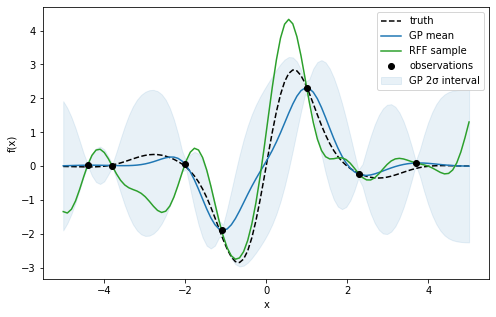

In [3]:
#collapse-hide
def rff_sample(gp):
    return pyrff.sample_rff(
        lengthscales=gp.kernel_.k1.k2.length_scale,
        scaling=gp.kernel_.k1.k1.constant_value,
        noise=gp.kernel_.k2.noise_level,
        kernel_nu=np.inf,  # degrees of freedom for a RBF
        X=X_obs[:, np.newaxis],
        Y=Y_obs,
        M=100  # number of Fourier features
    )

rff = rff_sample(gp)
y_rff = rff(x_grid[:, np.newaxis])

plot_data()
plot_gp()
plt.plot(x_grid, y_rff, "C2", label="RFF sample")
plt.legend();

We can draw a larger number of RFF approximates, and assess that they indeed follow the GP posterior.

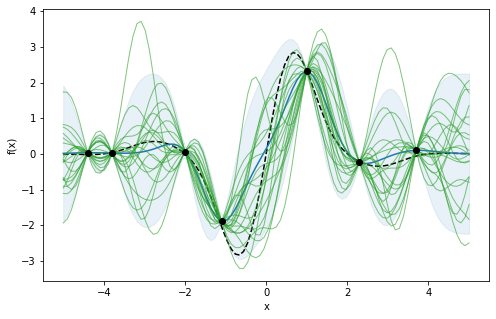

In [4]:
#collapse-hide
n_samples = 20
y_rff = np.empty((n_samples, 100))

for i in range(n_samples):
    rff = rff_sample(gp)
    y_rff[i] = rff(x_grid[:, np.newaxis])

plot_data()
plot_gp()
plt.plot(x_grid, y_rff.T, "C2", lw=1, alpha=0.6);

## Optimize on the RFF approximations

As RFF approximations are continuous functions in contrast to the sample *points* we usually get from the GP posterior, we apply iterative optimization to find their optima. 

Below the minima of each of the RFF approximates are plotted. For higher dimensions the grid search we applied here is not feasible and we could have also used a stochastic or deterministic global optimizer.
In effect each of these points is a sample from the posterior distribution of minimizer, $p(x^*|X,Y)$.

RFF approximates allow us to apply Thompson sampling in the context of Bayesian optimization. In the Bayesian optimization loop, we sample a single RFF approximate, find its optimizer $x^*$, and run the next experiment at this point.

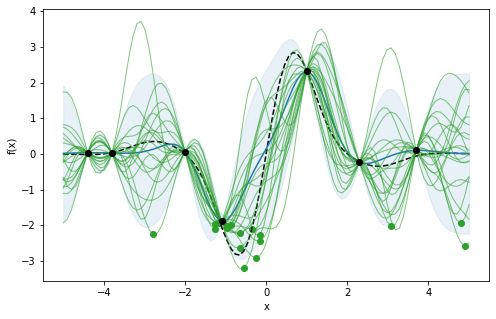

In [5]:
#collapse-hide
best = np.argmin(y_rff, axis=1)  # index of the minimizer
x_best = x_grid[best]
y_best = y_rff[np.arange(20), best]

plot_data()
plot_gp()
plt.plot(x_grid, y_rff.T, "C2", lw=1, alpha=0.6)
plt.scatter(x_best, y_best, color="C2");

## Other Matern kernels

With my [own implementation](https://davidwalz.github.io/blog/gaussian%20process/bayesian%20optimization/2020/05/03/gp-spectral-sampling.html) I had problems getting the Matern kernel other than RBF right.
Let's see if pyRFF does a better job.

In [6]:
#collapse-hide
def plot_rffs(nu):
    k_cov = skgp.kernels.Matern(1, (0.3, 5), nu=nu)
    k_scale = skgp.kernels.ConstantKernel(1, (0.2, 5))
    k_noise = skgp.kernels.WhiteKernel(noise_level=0.01)
    gp = skgp.GaussianProcessRegressor(kernel=k_scale * k_cov + k_noise)
    gp = gp.fit(X_obs[:, np.newaxis], Y_obs)

    y_mean, y_sigma = gp.predict(x_grid[:, np.newaxis], return_std=True)
    
    n_samples = 10
    y_rff = np.empty((n_samples, 100))
    for i in range(n_samples):
        rff = pyrff.sample_rff(
            lengthscales=gp.kernel_.k1.k2.length_scale,
            scaling=gp.kernel_.k1.k1.constant_value,
            noise=gp.kernel_.k2.noise_level,
            kernel_nu=nu,
            X=X_obs[:, np.newaxis],
            Y=Y_obs,
            M=100
        )
        y_rff[i] = rff(x_grid[:, np.newaxis])

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x_grid, y_mean, "C0")
    ax.fill_between(x_grid, y_mean - 2 * y_sigma, y_mean + 2 * y_sigma, alpha=.15, color="C0");
    ax.plot(x_grid, y_rff.T, "C2", lw=1, alpha=0.6)
    ax.set(xlabel="x", ylabel="f(x)");

### Exponential kernel

c:\users\walzds\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


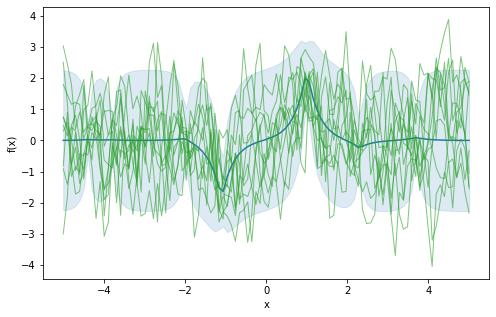

In [7]:
plot_rffs(nu=1/2)

### Matern-3/2

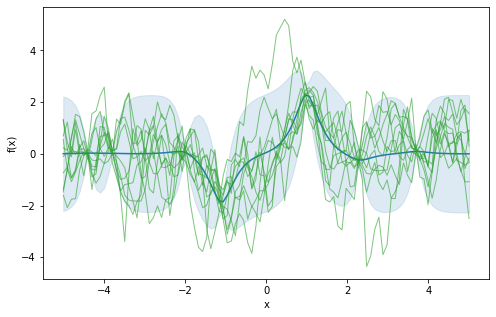

In [8]:
plot_rffs(nu=3/2)

### Matern-5/2

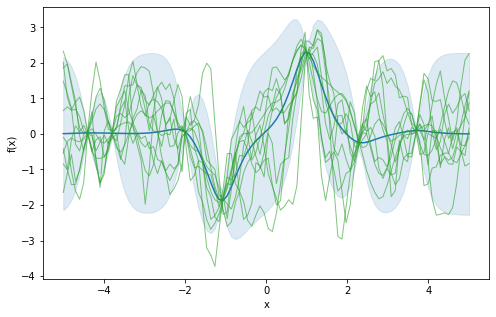

In [9]:
plot_rffs(nu=5/2)

Looks good!